# Data observation and data splitting
This notebook includes two parts
* Data observation
* Data splitting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import os
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Function for summary data

In [3]:
def summary_dataframe(data):
  
  # Counting null for each column
  null_counts = data.isnull().sum()
  summary_df = pd.DataFrame({"column_name":null_counts.index, "null_count":null_counts.values})

  # Calculating null for each column
  summary_df["null_rate"] = null_counts.values/len(data)

  # Counting unique elemnets for each column
  summary_df["elements"] = [len(set(data[column_name].to_list())) for column_name in data.columns]
  
  return summary_df

### Variables setting

In [4]:
# Default mount path on colab
DRIVE_MOUNT_PATH = "/content/drive"

# Project path on your google drive
# You can change this line 
PROJECT_PATH = "MyDrive/Fake-JD-Detector"

# Target or label column name
TARGET_COLUMN = "fraudulent"

### Execut this cell to mount your google drive

In [5]:
from google.colab import drive
drive.mount(DRIVE_MOUNT_PATH)

Mounted at /content/drive


## Loading data

In [6]:
job_postings_file = "job_postings_training_set.csv"
job_postings_path = os.path.join(DRIVE_MOUNT_PATH, PROJECT_PATH, job_postings_file)
job_postings_df = pd.read_csv(job_postings_path)

### Show data top 5 rows

In [7]:
job_postings_df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Summary about null value and distinct elements

In [8]:
summary_dataframe(job_postings_df)

,column_name,null_count,null_rate,elements
0,job_id,0,0.000000,17828
1,title,0,0.000000,11188
2,location,345,0.019352,3098
3,department,11514,0.645838,1338
4,salary_range,14966,0.839466,875
5,company_profile,3290,0.184541,1708
6,description,1,0.000056,14678
7,requirements,2688,0.150774,11882
8,benefits,7184,0.402962,6132
9,telecommuting,0,0.000000,2


### Show statistic of numerical data

In [9]:
job_postings_df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17828.000000,17828.000000,17828.000000,17828.000000,17828.000000
mean,8914.500000,0.042966,0.795434,0.491979,0.048351
std,5146.644635,0.202786,0.403395,0.499950,0.214513
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4457.750000,0.000000,1.000000,0.000000,0.000000
50%,8914.500000,0.000000,1.000000,0.000000,0.000000
75%,13371.250000,0.000000,1.000000,1.000000,0.000000
max,17828.000000,1.000000,1.000000,1.000000,1.000000


### Distribution of target column

In [10]:
job_postings_df[TARGET_COLUMN].value_counts().to_frame()

,fraudulent
0,16966
1,862


## Feature engineering

In [11]:
# Because of following steps will extend some columns, 
# so lat's copy a new dataframe
job_postings_extend_df = copy.deepcopy(job_postings_df)

In [12]:
# Using 0 length string ("") replace nan for more easy to detect
# In nefault, pandas use nan to represent missing values
# But nan is a float type value, it causes type inconsistency
job_postings_extend_df.fillna("", inplace=True)

### Is_null flag columns
Fake job postings may has missing values on some columns

In [13]:
# Add is_null column for all value-loss columns
# If value is "", means loss, set value 1 otherwise 0
null_counts = job_postings_df.isnull().sum()
for column, null_count in null_counts.items():
  if null_count == 0:
    continue
  job_postings_extend_df[column+"_is_null"] = (
      job_postings_extend_df[column].apply(lambda x: 0 if len(x) > 0 else 1)
  )

In [14]:
# Let me see some distribution
job_postings_extend_df.groupby(["company_profile_is_null", TARGET_COLUMN])["job_id"].count().reset_index()

,company_profile_is_null,fraudulent,job_id
0,0,0,14260
1,0,1,278
2,1,0,2706
3,1,1,584


### Spilt location to country, state, city

In [15]:
# Spilt location to country, state, city
split_column_names = ["location_country", "location_state", "location_city"]
job_postings_extend_df[split_column_names] = (
    job_postings_extend_df["location"]
    .str
    .split(pat=", ", n=2, expand=True)
)

<Axes: title={'center': 'Top 10 Job Located Countries'}>

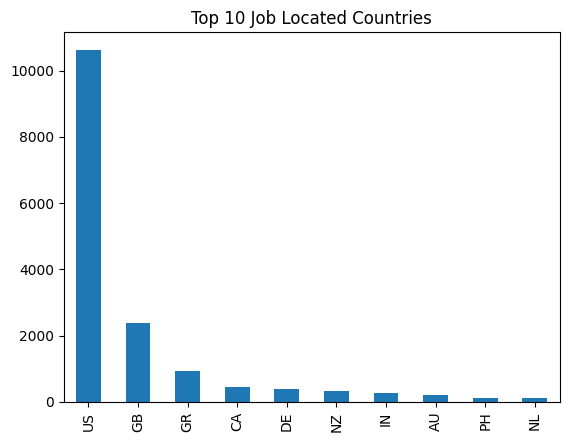

In [16]:
# Let me see top 10 job located countries
(
 job_postings_extend_df
 .loc[job_postings_extend_df["location_country"].str.len()>0, "location_country"]
 .value_counts()
 .iloc[:10]
 .plot(kind="bar", title="Top 10 Job Located Countries")
)

### Processing salary range to numerical data type

In [17]:
# Processing salary range to numerical
salary_range_lows, salary_range_ups, salary_range_diff = [], [], []
for salary_range in job_postings_extend_df["salary_range"].tolist():
    
    range_split, range_low, range_up =[], -1, -1
    
    if len(salary_range) > 0:
        range_split = re.sub(r"[^0-9\-]+", "", salary_range).split("-")
    
    if len(range_split) == 2 and len(range_split[0]) > 0 and len(range_split[1]) > 0:
        range_low, range_up = range_split
        
    salary_range_lows.append(int(range_low))
    salary_range_ups.append(int(range_up))
    salary_range_diff.append(int(range_up)-int(range_low))
    
job_postings_extend_df["salary_range_low"] = salary_range_lows
job_postings_extend_df["salary_range_up"] = salary_range_ups
job_postings_extend_df["salary_range_diff"] = salary_range_diff

<Axes: title={'center': 'Top 10 Salary Range Differences'}>

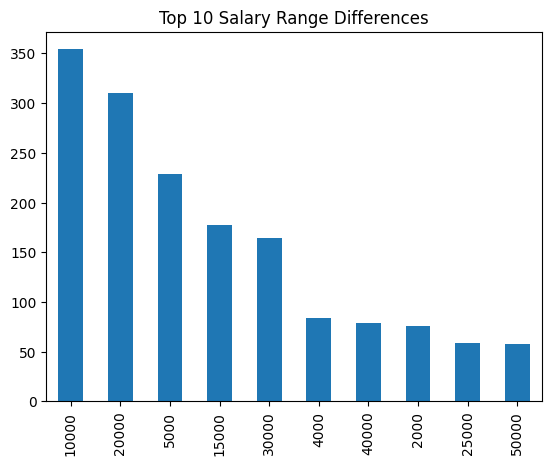

In [18]:
# Let me see top 10 salary range differences
(
 job_postings_extend_df
 .loc[job_postings_extend_df["salary_range_diff"]>0, "salary_range_diff"]
 .value_counts()
 .iloc[:10]
 .plot(kind="bar", title="Top 10 Salary Range Differences")
)

### Some references inspire me

* [Kaggle: Real/Fake Job Posting Prediction](https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction)

In [19]:
# Combine string type data to text
job_postings_extend_df["posting_text"] = (
    job_postings_extend_df["title"]+" "+
    job_postings_extend_df["location"]+" "+
    job_postings_extend_df["company_profile"]+" "+
    job_postings_extend_df["description"]+" "+
    job_postings_extend_df["requirements"]+" "+
    job_postings_extend_df["benefits"]
)

# Clean text, only keep a-z, A-Z, 0-9 characters
# In formal texts, special symbols usually can be mean as space
job_postings_extend_df["posting_text_cleaned"] = (
    job_postings_extend_df["posting_text"]
    .apply(lambda x: re.sub(r"[\s]+", " ", re.sub(r"[^a-zA-Z0-9]+"," ", x)).strip())
)

In [20]:
# Calculating length of text type columns
text_columns = [
    "company_profile", "description", "requirements", 
    "benefits", "posting_text", "posting_text_cleaned"
]
for text_column in text_columns:
    job_postings_extend_df[text_column+"_len"] = (
        job_postings_extend_df[text_column].apply(lambda x: len(x))
    )

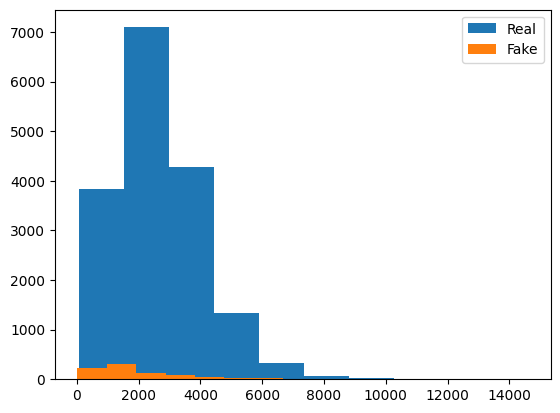

In [21]:
# Let me see real/fake job postings text length distribution
posting_text_cleaned_len_real = (
    job_postings_extend_df.loc[
        job_postings_extend_df[TARGET_COLUMN]==0,
        "posting_text_cleaned_len"
    ]
    .to_list()
)

posting_text_cleaned_len_fake = (
    job_postings_extend_df.loc[
        job_postings_extend_df[TARGET_COLUMN]==1,
        "posting_text_cleaned_len"
    ]
    .to_list()
)

plt.hist(posting_text_cleaned_len_real, label="Real")
plt.hist(posting_text_cleaned_len_fake, label="Fake")
plt.legend(loc="upper right")
plt.show()

## Split Data to Train and Validation
Split 80% to training and 20% to validation

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    job_postings_extend_df["posting_text_cleaned"], 
    job_postings_extend_df[TARGET_COLUMN], 
    test_size = 0.20, 
    stratify=job_postings_extend_df[TARGET_COLUMN], 
    random_state = 777
)

train_df = pd.DataFrame({"text": X_train, "fraudulent": y_train})
test_df = pd.DataFrame({"text": X_test, "fraudulent": y_test})

output_destination = os.path.join(DRIVE_MOUNT_PATH, PROJECT_PATH, "splitted_text_data")

train_df.to_csv(output_destination+"/train.csv", index=False)
test_df.to_csv(output_destination+"/validation.csv", index=False)